In [2]:
import pandas as pd
import cv2
import numpy as np
from datetime import datetime
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, Flatten, Concatenate, TimeDistributed, Conv2D, MaxPooling2D
from tensorflow.keras.applications import VGG16
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import optuna
import os
import tensorflow as tf
from tensorflow.keras.layers import PReLU
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import GlobalAveragePooling2D

In [3]:
# Funciones
# Función para convertir el formato de timestamp del DataFrame al formato de los nombres de las imágenes
def get_closest_image_path(timestamp, image_folder):
    base_image_name = f'OR_ABI-L2-ACMF-M6_G16_s{timestamp.strftime("%Y%m%d%H%M")}'
    for second in range(60):
        image_name = f"{base_image_name}{second:02d}.png"
        image_path = os.path.join(image_folder, image_name)
        if os.path.exists(image_path):
            return image_path
    return None

# Cargar imágenes y valores GHI normalizados, con imágenes redimensionadas
def load_images_and_ghi(df_filtrado, image_folder):
    images = []
    ghi_values = []
    doy_sin = []
    doy_cos = []
    
    for idx, row in df_filtrado.iterrows():
        timestamp = row['Timestamp']
        ghi_value = row['GHI']
        doy_sin_value = row['DoY Sin']
        doy_cos_value = row['DoY Cos']
        image_path = get_closest_image_path(timestamp, image_folder)
         
        img = cv2.imread(image_path)
        
        if img is not None:
            # Redimensionar la imagen a 64x64 píxeles y normalizar dividiendo por 255
            img_resized = cv2.resize(img, (64, 64)) / 255.0
            images.append(img_resized)
            ghi_values.append(ghi_value)
            doy_sin.append(doy_sin_value)
            doy_cos.append(doy_cos_value)
        else:
            print(f"Imagen no encontrada: {image_path}")
    
    # Normalizar los valores GHI
    ghi_values = np.array(ghi_values).reshape(-1, 1)
    scaler = MinMaxScaler()
    ghi_values_scaled = scaler.fit_transform(ghi_values)
    
    # Convertir doy_sin y doy_cos a numpy arrays
    doy_sin = np.array(doy_sin).reshape(-1, 1)
    doy_cos = np.array(doy_cos).reshape(-1, 1)
    
    return np.array(images), ghi_values_scaled, scaler, doy_sin, doy_cos


# Preparar secuencias para la LSTM
def create_sequences(images, aux_features, ghi_values, time_steps):
    X_images_seq = []
    X_aux_seq = []
    y_seq = []

    for i in range(len(images) - time_steps):
        # Crear secuencia de imágenes de longitud `time_steps`
        X_images_seq.append(images[i:i + time_steps])
        
        # Crear secuencia de características auxiliares de longitud `time_steps`
        X_aux_seq.append(aux_features[i:i + time_steps])
        
        # La variable objetivo es el valor GHI justo después del último paso de la secuencia
        y_seq.append(ghi_values[i + time_steps])

    return np.array(X_images_seq), np.array(X_aux_seq), np.array(y_seq)


In [4]:
# Cargar datos y preparar el conjunto de entrenamiento
df = pd.read_pickle('/home/aia-workstation/Documents/Santiago/Modelo/Cloud_Forecasting_CNN_LSTM/df_GHI.plk')

# 1. Definir el rango de fechas para el entrenamiento
fecha_inicio_entrenamiento = '2023-01-01 05:00:00'  # Fecha de inicio de entrenamiento
fecha_fin_entrenamiento = '2023-02-28 18:30:00'  # Fecha de fin de entrenamiento

# Filtrar el DataFrame por el rango de entrenamiento
df['Timestamp'] = pd.to_datetime(df['Timestamp'])  # Asegurar que la columna Timestamp sea de tipo datetime
df_entrenamiento = df[(df['Timestamp'] >= fecha_inicio_entrenamiento) & (df['Timestamp'] <= fecha_fin_entrenamiento)]

# Cargar imágenes y valores GHI para el entrenamiento
image_folder = '/home/aia-workstation/Documents/Santiago/Modelo/Cloud_Forecasting_CNN_LSTM/Images/ACMF'
X_images_train, y_ghi_train, scaler_train, doy_sin_train, doy_cos_train = load_images_and_ghi(df_entrenamiento, image_folder)

# Concatenar DOY sin y cos con las imágenes
X_aux_features_train = np.concatenate([doy_sin_train, doy_cos_train], axis=1)

# Crear las secuencias con time_steps = 6
time_steps = 12
X_images_train_seq, X_aux_train_seq, y_train_seq = create_sequences(X_images_train, X_aux_features_train, y_ghi_train, time_steps)

Imagen no encontrada: None


[ WARN:0@562.977] global loadsave.cpp:241 findDecoder imread_(''): can't open/read file: check file path/integrity


Imagen no encontrada: None


[ WARN:0@565.592] global loadsave.cpp:241 findDecoder imread_(''): can't open/read file: check file path/integrity


Imagen no encontrada: None
Imagen no encontrada: None


[ WARN:0@568.203] global loadsave.cpp:241 findDecoder imread_(''): can't open/read file: check file path/integrity
[ WARN:0@568.265] global loadsave.cpp:241 findDecoder imread_(''): can't open/read file: check file path/integrity


Imagen no encontrada: None


[ WARN:0@569.150] global loadsave.cpp:241 findDecoder imread_(''): can't open/read file: check file path/integrity


Imagen no encontrada: None
Imagen no encontrada: None


[ WARN:0@570.802] global loadsave.cpp:241 findDecoder imread_(''): can't open/read file: check file path/integrity
[ WARN:0@570.863] global loadsave.cpp:241 findDecoder imread_(''): can't open/read file: check file path/integrity


In [5]:

def create_vgg16_lstm(de1,de2,a1,a2):
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(64, 64, 3))
    for layer in base_model.layers[:15]:
        layer.trainable = False  # Congelar las primeras capas
    
    model = Sequential()
    model.add(base_model)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(de1, activation=a1))
    model.add(Dense(de2, activation=a2))
    model.add(Flatten())
    return model

# Definir la función objetivo para Optuna
def objective(trial):
    # Definir los hiperparámetros a optimizar
    lstm_units = trial.suggest_int('lstm_units', 32, 128)
    dense_units_1 = trial.suggest_int('dense_units_1', 32, 128)
    dense_units_2 = trial.suggest_int('dense_units_2', 16, 64)
    dropout_rate = trial.suggest_float('dropout_rate', 0.2, 0.5)
    f1=trial.suggest_int('f1',50,350)
    f2=trial.suggest_int('f2',50,350)

    op_act = ["relu",'softplus'] 
    a1 = trial.suggest_categorical('a1',op_act)
    a2 = trial.suggest_categorical('a2',op_act)
    kwargs = {}
    optimizer_options = ["RMSprop", "Adam", "SGD"]
    optimizer_selected = trial.suggest_categorical("optimizer", optimizer_options)
    if optimizer_selected == "RMSprop":
        kwargs["learning_rate"] = trial.suggest_float(
            "rmsprop_learning_rate", 1e-5, 1e-1, log=True
        )
        kwargs["weight_decay"] = trial.suggest_float("rmsprop_weight_decay", 0.85, 0.99)
        kwargs["momentum"] = trial.suggest_float("rmsprop_momentum", 1e-5, 1e-1, log=True)
    elif optimizer_selected == "Adam":
        kwargs["learning_rate"] = trial.suggest_float("adam_learning_rate", 1e-5, 1e-1, log=True)
    elif optimizer_selected == "SGD":
        kwargs["learning_rate"] = trial.suggest_float(
            "sgd_opt_learning_rate", 1e-5, 1e-1, log=True
        )
        kwargs["momentum"] = trial.suggest_float("sgd_opt_momentum", 1e-5, 1e-1, log=True)

    optimizer1 = getattr(tf.optimizers, optimizer_selected)(**kwargs)

    # Definir el modelo CNN Dual + LSTM
    # 1. CNN para procesar las imágenes
    image_input = Input(shape=(time_steps, 64, 64, 3))



    cnn = create_vgg16_lstm(f1,f2,a1,a2)
    time_distributed_cnn = TimeDistributed(cnn)(image_input)

    # 2. LSTM para modelar la secuencia de características visuales extraídas
    lstm = LSTM(lstm_units, return_sequences=False)(time_distributed_cnn)

    # 3. Procesar las características auxiliares (doy_sin, doy_cos)
    aux_input = Input(shape=(time_steps, 2))
    aux_lstm = LSTM(32, return_sequences=False)(aux_input)

    # 4. Concatenar la salida de la LSTM de imágenes y la LSTM de características auxiliares
    concatenated = Concatenate()([lstm, aux_lstm])
    concatenated = Dense(dense_units_1, activation='relu')(concatenated)
    concatenated = Dense(dense_units_2, activation='relu')(concatenated)
    concatenated = Dropout(dropout_rate)(concatenated)

    # 5. Salida final
    dense_output = Dense(1, activation='linear')(concatenated)

    # Definir el modelo
    model = Model(inputs=[image_input, aux_input], outputs=dense_output)

    # Compilar el modelo
    model.compile(optimizer=optimizer1, loss='mse', metrics=['mae'])

    # Entrenar el modelo
    history = model.fit(
        [X_images_train_seq, X_aux_train_seq],
        y_train_seq,
        epochs=10,
        batch_size=32,
        validation_split=0.2,
        verbose=0  # Silenciar la salida
    )

    # Devolver la métrica de validación para la optimización
    val_loss = min(history.history['val_loss'])
    return val_loss

# Crear un estudio de Optuna y ejecutar la optimización
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=20)

# Mostrar los mejores hiperparámetros encontrados
print("Mejores Hiperparámetros:", study.best_params)

# Guardar el modelo con los mejores hiperparámetros
best_params = study.best_params

# Definir el modelo final con los mejores hiperparámetros
image_input = Input(shape=(time_steps, 64, 64, 3))
cnn = create_vgg16_lstm(best_params['f1'],best_params['f2'],best_params['a1'],best_params['a2'])
time_distributed_cnn = TimeDistributed(cnn)(image_input)

lstm = LSTM(best_params['lstm_units'], return_sequences=False)(time_distributed_cnn)

aux_input = Input(shape=(time_steps, 2))
aux_lstm = LSTM(32, return_sequences=False)(aux_input)

concatenated = Concatenate()([lstm, aux_lstm])
concatenated = Dense(best_params['dense_units_1'], activation='relu')(concatenated)
concatenated = Dense(best_params['dense_units_2'], activation='relu')(concatenated)
concatenated = Dropout(best_params['dropout_rate'])(concatenated)

dense_output = Dense(1, activation='linear')(concatenated)

model = Model(inputs=[image_input, aux_input], outputs=dense_output)
model.compile(optimizer=best_params['optimizer'], loss='mse', metrics=['mae'])

# Entrenar el modelo final
model.fit([X_images_train_seq, X_aux_train_seq], y_train_seq, epochs=50, batch_size=32, validation_split=0.2)

# Guardar el modelo
model.save('/home/aia-workstation/Documents/Juan F/M-1/CNN_lstm_model_v5.h5')


[I 2024-11-25 17:43:34,651] A new study created in memory with name: no-name-2caec434-47bc-490f-b25d-bcc4dc6471db
I0000 00:00:1732574614.657353 1489117 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-11-25 17:43:34.657596: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2343] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
/home/aia-workstation/anaconda3/lib/python3.12/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor', '

Mejores Hiperparámetros: {'lstm_units': 76, 'dense_units_1': 125, 'dense_units_2': 36, 'dropout_rate': 0.29957767684444997, 'f1': 265, 'f2': 240, 'a1': 'relu', 'a2': 'softplus', 'optimizer': 'Adam', 'adam_learning_rate': 0.000184066021265292}
Epoch 1/50


/home/aia-workstation/anaconda3/lib/python3.12/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_920', 'keras_tensor_959']. Received: the structure of inputs=('*', '*')
  warnings.warn(


121/121 ━━━━━━━━━━━━━━━━━━━━ 101s 803ms/step - loss: 0.1262 - mae: 0.3008 - val_loss: 0.1061 - val_mae: 0.2926
Epoch 2/50
121/121 ━━━━━━━━━━━━━━━━━━━━ 96s 794ms/step - loss: 0.0935 - mae: 0.2700 - val_loss: 0.1144 - val_mae: 0.2976
Epoch 3/50
121/121 ━━━━━━━━━━━━━━━━━━━━ 96s 795ms/step - loss: 0.0928 - mae: 0.2687 - val_loss: 0.1039 - val_mae: 0.2924
Epoch 4/50
121/121 ━━━━━━━━━━━━━━━━━━━━ 96s 795ms/step - loss: 0.0931 - mae: 0.2700 - val_loss: 0.1062 - val_mae: 0.2930
Epoch 5/50
121/121 ━━━━━━━━━━━━━━━━━━━━ 96s 795ms/step - loss: 0.0942 - mae: 0.2716 - val_loss: 0.1064 - val_mae: 0.2929
Epoch 6/50
121/121 ━━━━━━━━━━━━━━━━━━━━ 96s 795ms/step - loss: 0.0904 - mae: 0.2678 - val_loss: 0.1144 - val_mae: 0.2976
Epoch 7/50
121/121 ━━━━━━━━━━━━━━━━━━━━ 96s 795ms/step - loss: 0.0909 - mae: 0.2681 - val_loss: 0.1061 - val_mae: 0.2926
Epoch 8/50
121/121 ━━━━━━━━━━━━━━━━━━━━ 96s 795ms/step - loss: 0.0888 - mae: 0.2663 - val_loss: 0.1078 - val_mae: 0.2937
Epoch 9/50
121/121 ━━━━━━━━━━━━━━━━━━━━ 96

Imagen no encontrada: None


[ WARN:0@24663.064] global loadsave.cpp:241 findDecoder imread_(''): can't open/read file: check file path/integrity


Imagen no encontrada: None
Imagen no encontrada: None
Imagen no encontrada: None
Imagen no encontrada: None


[ WARN:0@24663.460] global loadsave.cpp:241 findDecoder imread_(''): can't open/read file: check file path/integrity
[ WARN:0@24663.475] global loadsave.cpp:241 findDecoder imread_(''): can't open/read file: check file path/integrity
[ WARN:0@24663.475] global loadsave.cpp:241 findDecoder imread_(''): can't open/read file: check file path/integrity
[ WARN:0@24663.479] global loadsave.cpp:241 findDecoder imread_(''): can't open/read file: check file path/integrity
/home/aia-workstation/anaconda3/lib/python3.12/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_920', 'keras_tensor_959']. Received: the structure of inputs=('*', '*')
  warnings.warn(


38/38 ━━━━━━━━━━━━━━━━━━━━ 21s 537ms/step
MAE en el conjunto de prueba: 0.22653418669962752
RMSE en el conjunto de prueba: 0.26366877292282026


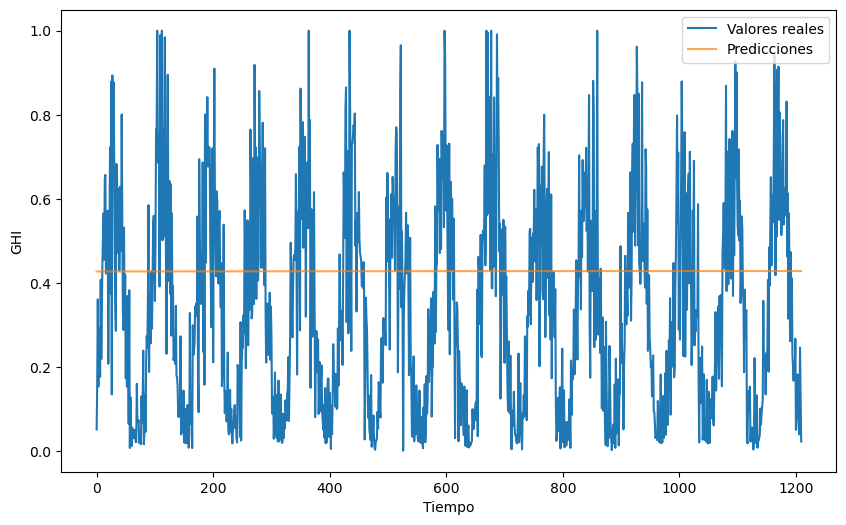

In [6]:

# Probar el modelo
# Preparar el conjunto de prueba
fecha_inicio_prueba = '2023-03-15 05:00:00'  # Fecha de inicio de prueba
fecha_fin_prueba = '2023-03-29 18:00:00'  # Fecha de fin de prueba

# Filtrar el DataFrame por el rango de prueba
df_prueba = df[(df['Timestamp'] >= fecha_inicio_prueba) & (df['Timestamp'] <= fecha_fin_prueba)]

# Cargar imágenes y valores GHI para el conjunto de prueba
X_images_test, y_ghi_test, scaler_test, doy_sin_test, doy_cos_test = load_images_and_ghi(df_prueba, image_folder)

# Concatenar DOY sin y cos con las imágenes de prueba
X_aux_features_test = np.concatenate([doy_sin_test, doy_cos_test], axis=1)

# Crear las secuencias de prueba con time_steps = 6
X_images_test_seq, X_aux_test_seq, y_test_seq = create_sequences(X_images_test, X_aux_features_test, y_ghi_test, time_steps)

# Hacer predicciones
y_pred = model.predict([X_images_test_seq, X_aux_test_seq])

# Invertir la normalización para GHI
y_test_seq_inversed = scaler_test.inverse_transform(y_test_seq)
y_pred_inversed = scaler_test.inverse_transform(y_pred)

# Evaluar el modelo
from sklearn.metrics import mean_absolute_error, mean_squared_error

mae = mean_absolute_error(y_test_seq_inversed, y_pred_inversed)
rmse = np.sqrt(mean_squared_error(y_test_seq_inversed, y_pred_inversed))

print(f'MAE en el conjunto de prueba: {mae}')
print(f'RMSE en el conjunto de prueba: {rmse}')

# Visualizar algunas predicciones
plt.figure(figsize=(10, 6))
plt.plot(y_test_seq_inversed, label='Valores reales')
plt.plot(y_pred_inversed, label='Predicciones', alpha=0.7)
plt.xlabel('Tiempo')
plt.ylabel('GHI')
plt.legend()
plt.show()